# Optic Disc Segmentation

In [26]:
%matplotlib inline

import os
import os.path
import cv2
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt


mpl.rcParams['figure.dpi'] = 300

## Load the Images
Note to self: for consistency across platforms within my own repository structure, always run `jupyter notebook` from the root of this git repo `COMP9517`.

In [27]:
# repo_path = os.getcwd()
# data_path = os.path.join(repo_path, "assignments", "ass2", "Data_Individual_Component")

# retinal_images_path = os.path.join(data_path, "original_retinal_images")
# truth_masks_path = os.path.join(data_path, "optic_disc_segmentation_masks")

retinal_images_path = os.path.join("Data_Individual_Component", "original_retinal_images")
truth_masks_path = os.path.join("Data_Individual_Component", "optic_disc_segmentation_masks")

def get_mask_name(image_name):
    basename = os.path.splitext(image_name)[0]
    return basename + '_OD.tif'
    

image_names = os.listdir(retinal_images_path) 
mask_names = list(map(get_mask_name, image_names))

retinal_images_names = list(map(lambda x: os.path.join(retinal_images_path, x), image_names))
truth_masks_names = list(map(lambda x: os.path.join(truth_masks_path, x), mask_names))

df = pd.DataFrame({"image_path": retinal_images_names, "mask_path": truth_masks_names})

## Read the image

In [28]:
from skimage.morphology import extrema

def showImage(image):
    cv2.imshow("PRESS Q TO QUIT ME", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
def compare(img1, img2):
    fig, axes = plt.subplots(1,2)
    axes[0].axis('off')
    axes[1].axis('off')

    axes[0].imshow(img1,cmap='gray')
    axes[1].imshow(img2,cmap='gray')

sample = df.sample(1).iloc[0,:]


In [29]:
print(sample["image_path"])
print(sample["mask_path"])

Data_Individual_Component\original_retinal_images\IDRiD_34.jpg
Data_Individual_Component\optic_disc_segmentation_masks\IDRiD_34_OD.tif


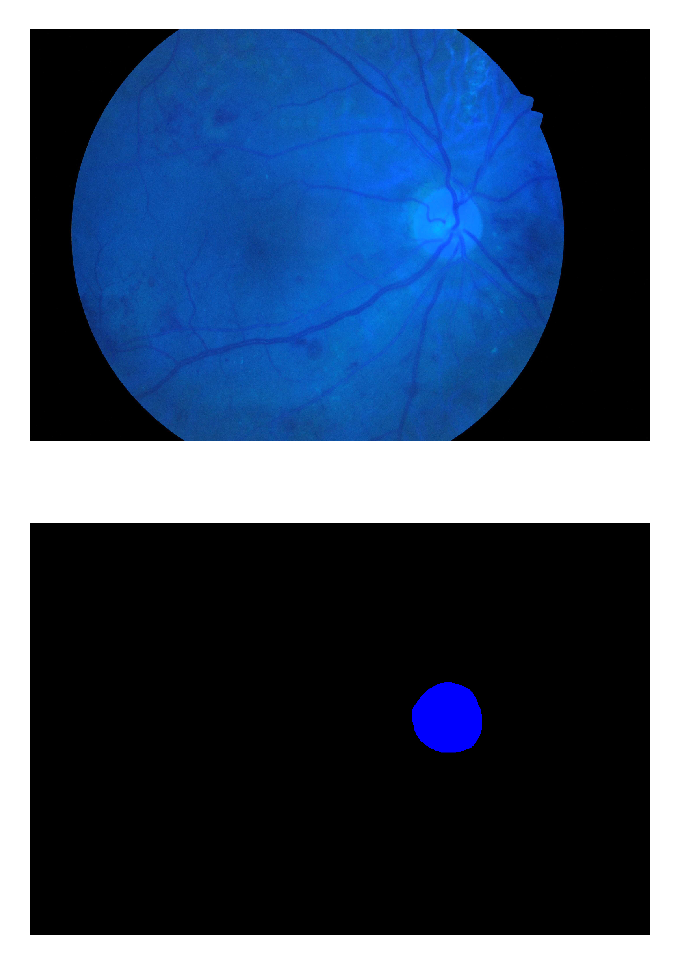

In [76]:

orig_img = cv2.imread(sample["image_path"])
truth_mask = cv2.imread(sample["mask_path"])

# downscale the image
height = 1046
width = int(1046 * orig_img.shape[1] / orig_img.shape[0])

orig_img = cv2.resize(orig_img, (width, height))
truth_mask = cv2.resize(mask, (width, height))

img = np.copy(orig_img)

fig, axes = plt.subplots(2,1)
axes[0].axis("off")
axes[1].axis("off")

axes[0].imshow(img)
axes[1].imshow(truth_mask)

## Locate OD Centre

### Find Centre by Maxmimunm Difference within Window

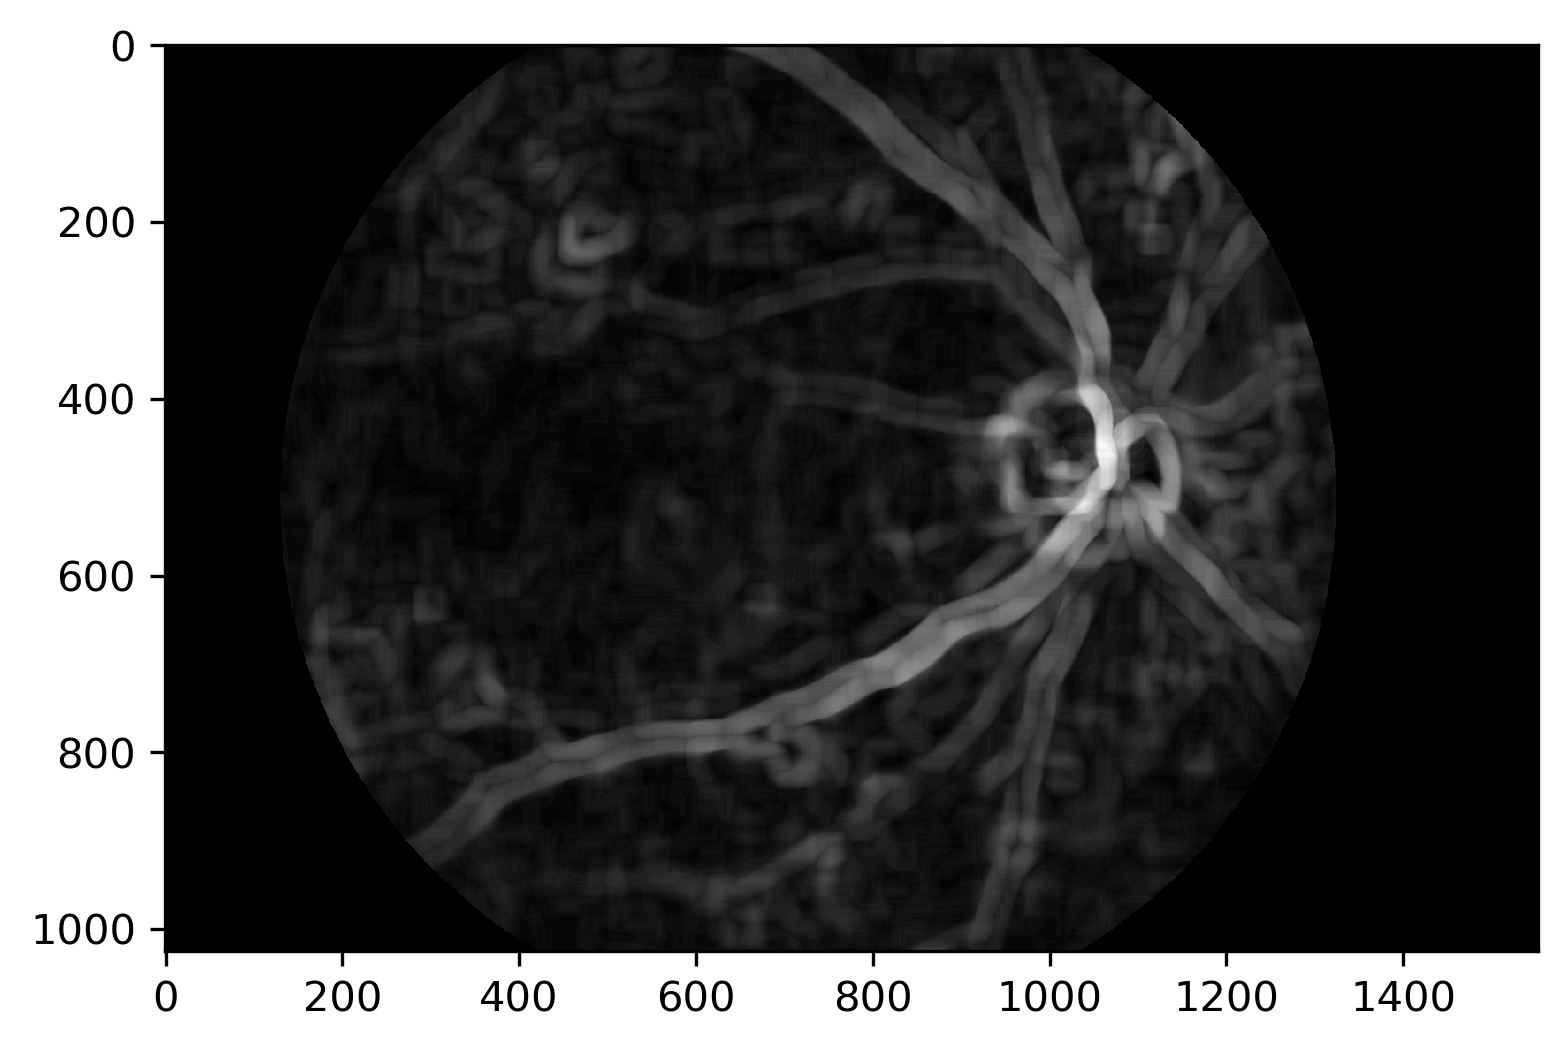

In [31]:
# Maximum difference model
img_1 = np.copy(img)
img_1_g = img_1[:,:,1]
plt.imshow(img_1_g)

window_size = 21
filtered = cv2.medianBlur(img_1_g, ksize=window_size)

sh = filtered.shape
shape = (sh[0] - window_size, sh[1] - window_size)

windows = []

for row in range(shape[0]):
    for col in range(shape[1]):
        roi = filtered[row:row+window_size,col:col+window_size]
        windows.append(roi)
        
windows = np.array(windows, dtype=np.uint8)
        
maxes = np.max(windows, axis=(1,2))
mins = np.min(windows, axis=(1,2))
differences = maxes-mins
differences = np.reshape(differences, shape)

# bounding box of retina
thresh, bw = cv2.threshold(differences, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

left_edge = 100
while left_edge < shape[1]:
    col = bw[:,left_edge]
    if max(col) > 0:
        break
    left_edge += 1
    
right_edge = shape[1] - 1
while right_edge > 0:
    col = bw[:,right_edge]
    if max(col) > 0:
        break
    right_edge -= 1

border_thickness = 30
    
midline = int((left_edge+right_edge)/2)
radius = int((right_edge-left_edge)/2) - border_thickness
centre = midline, int(shape[0]/2)

mask = np.array(cv2.circle(np.zeros(shape), centre, radius, 1, -1, cv2.FILLED), dtype=np.uint8)
masked = cv2.bitwise_and(differences, differences, mask=mask)

_,_,_,max_loc_diff = cv2.minMaxLoc(masked)

debug_img = np.copy(differences)
debug_img = cv2.circle(debug_img, max_loc_diff, 5, 255, 2, cv2.FILLED)

plt.imshow(masked, cmap='gray')

### Find Centre by Max Variance within Window

In [33]:
windows_variance = []

for row in range(shape[0]):
    for col in range(shape[1]):
        roi = filtered[row:row+window_size,col:col+window_size]
        windows_variance.append(roi)
        
windows_variance = np.array(windows_variance, dtype=np.uint8)


variances = np.var(windows_variance, axis=(1,2))
variances = np.reshape(variances, shape)
variances = np.multiply(variances, mask)
variances.shape

_,_,_,max_loc_var = cv2.minMaxLoc(variances)
debug_img = cv2.circle(debug_img, max_loc_var, 10, 255, 2, cv2.FILLED)

In [34]:
showImage(debug_img)

### Find Maximum Value after Low Pass Filter

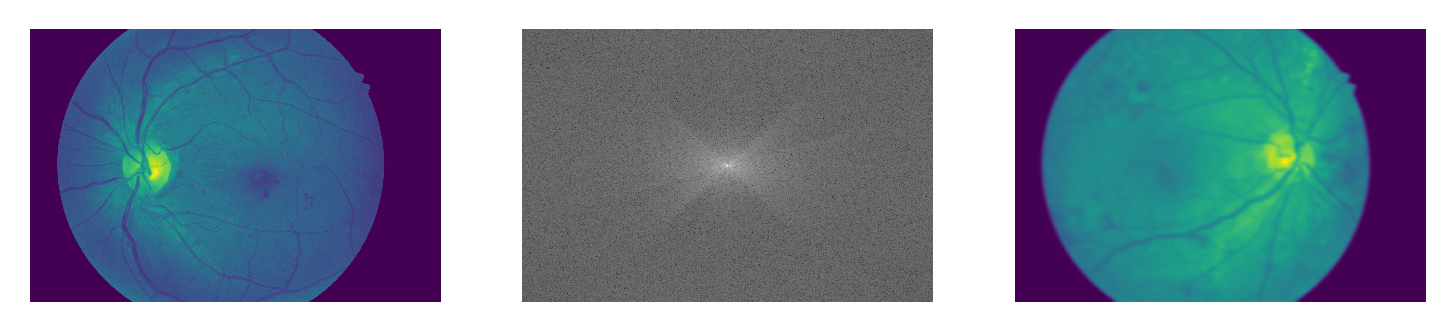

In [35]:
# Low Pass Filter

img3 = np.copy(orig_img)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img3_g = img3[:,:,1]

f = np.fft.fft2(img3_g)
fshift = np.fft.fftshift(f)

shape_2 = img3_g.shape

magnitude_spectrum = 20 * np.log(np.abs(fshift))

centre_point = shape_2[0]/2, shape_2[1]/2

# low pass gaussian filter in frequency domain with cutoff
cutoff = 25 # cutoff in hz
for row in range(shape_2[0]):
    for col in range(shape_2[1]):
        dist = np.linalg.norm(np.array(centre_point) - np.array((row,col)))
        fshift[row,col] = fshift[row,col] * np.exp(-(dist**2)/((2*cutoff)**2))

f_ishift = np.fft.ifftshift(fshift)
reconstructed = np.fft.ifft2(f_ishift)
reconstructed = np.real(reconstructed)

fig, axes = plt.subplots(1,3)

_,_,_,max_loc_lpg = cv2.minMaxLoc(reconstructed)

debug_img = cv2.circle(debug_img, max_loc_lpg, 20, 255, 2, cv2.FILLED)

axes[0].axis('off')
axes[0].imshow(img2_g)
axes[1].axis('off')
axes[1].imshow(magnitude_spectrum, cmap='gray')
axes[2].axis('off')
axes[2].imshow(reconstructed)

In [37]:
showImage(debug_img)

(1025, 1553)

## Find the voted centre point

In [38]:
centroid = np.array((int((max_loc_lpg[0]+max_loc_diff[0]+max_loc_var[0])/3), int((max_loc_lpg[1]+max_loc_diff[1]+max_loc_var[1])/3)))
close_thresh = height / 5

centres = np.array([max_loc_var, max_loc_lpg, max_loc_diff])
distances = np.array([np.linalg.norm(centroid - centre) for centre in centres])

viable = centres[np.where(distances < close_thresh)]

if len(viable) == 2:
    centroid = (int((viable[0,0] + viable[1,0])/2), int((viable[1,0] + viable[1,1])/2))

In [40]:
rect_radius = 200
rect_top_left = (centroid[0] - rect_radius, centroid[1] - rect_radius)
rect_bottom_right = (centroid[0] + rect_radius, centroid[1] + rect_radius)

debug_img = cv2.rectangle(debug_img, rect_top_left, rect_bottom_right, 255, 2)
showImage(debug_img)

In [41]:
# sometimes the method works better on green and sometimes on red

candidate_r = orig_img[rect_top_left[1]:rect_bottom_right[1],rect_top_left[0]:rect_bottom_right[0],2]
candidate_g = orig_img[rect_top_left[1]:rect_bottom_right[1],rect_top_left[0]:rect_bottom_right[0],1]

showImage(candidate_r)

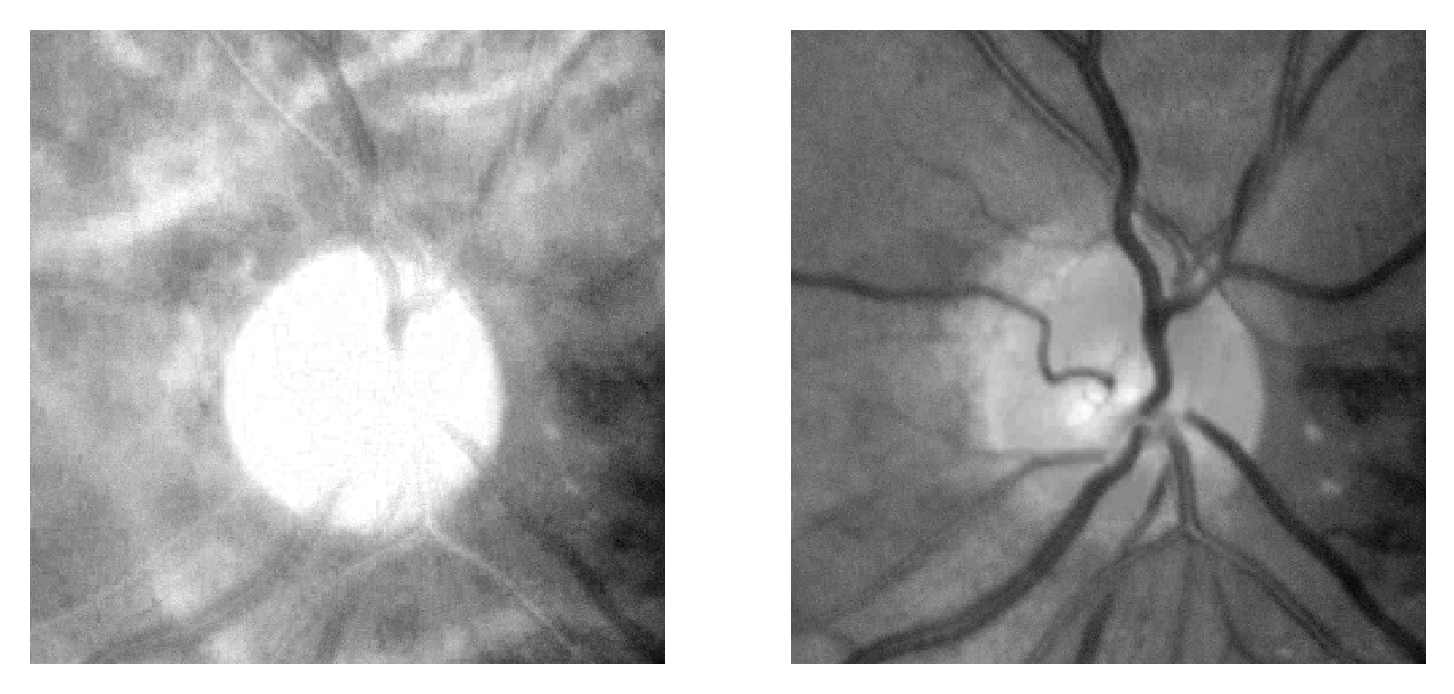

In [42]:
compare(candidate_r, candidate_g)

In [43]:
## Credit to user mohikhsan on stackoverflow https://stackoverflow.com/a/32857432/4368930 to provide a LineIterator function
## that mirrors the functionality in the C++ OpenCV api

def createLineIterator(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])     
    """
    #define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
    itbuffer.fill(np.nan)

    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X: #vertical line segment
        itbuffer[:,0] = P1X
        if negY:
                itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
        else:
                itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
    elif P1Y == P2Y: #horizontal line segment
        itbuffer[:,1] = P1Y
        if negX:
                itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
        else:
                itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
    else: #diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
                slope = dX.astype(np.float32)/dY.astype(np.float32)
                if negY:
                    itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
                else:
                    itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
                itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(np.int) + P1X
        else:
                slope = dY.astype(np.float32)/dX.astype(np.float32)
                if negX:
                    itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
                else:
                    itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
                itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(np.int) + P1Y

    #Remove points outside of image
    colX = itbuffer[:,0]
    colY = itbuffer[:,1]
    itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

    #Get intensities from img ndarray
    itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

    return itbuffer

### Remove blood vessels

In [44]:
def remove_vasculature(candidate):
    roi = np.copy(candidate)
    filter_length = 27
    rows, cols = roi.shape
    for i in range(rows):
        if(i % 20 == 0):
            print("Row", i)
        for j in range(cols):
            ## get the structuring elements of this centrepoint
            elem_intensities = []
            elem_indices = []
            for rot in np.arange(0,180,15):
                angle = rot * np.pi / 180
                r = filter_length/2
                elev = (r * np.sin(angle))
                run = (r * np.cos(angle))
                tl = np.array((j + elev, i + run), dtype=np.int32)
                br = np.array((j - elev, i - run), dtype=np.int32)
                pts = createLineIterator(tl, br, candidate)
                
                indices = np.array(pts[:,0:2], dtype=np.int32)
                intensities = pts[:,2]
                elem_intensities.append(intensities)
                elem_indices.append(indices)
                
        
            elem_vars = list(map(np.var, elem_intensities))

            idx = np.argmax(elem_vars)
            max_val = np.max(elem_intensities[idx])
            indicies = np.array(elem_indices[idx])

            xs = indicies[:,0]
            ys = indicies[:,1]
            
            roi[i,j] = max_val
            
            
    return roi
                

### Obtain Candidate Edges by Prewitt Edge Detector

In [46]:
def prewitt_filter(img):
    kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    kernelx_rev = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
    kernely_rev = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
    prewittx = cv2.filter2D(img, -1, kernelx)
    prewitty = cv2.filter2D(img, -1, kernely)
    prewittx_rev = cv2.filter2D(img, -1, kernelx_rev)
    prewitty_rev = cv2.filter2D(img, -1, kernely_rev)
    prewitt_forward = np.sqrt(np.square(prewittx) + np.square(prewitty))
    prewitt_backward = np.sqrt(np.square(prewittx_rev) + np.square(prewitty_rev))
    
    prewitt = np.array(prewitt_forward + prewitt_backward, dtype=np.uint8)
    
    print(np.max(prewitt))
    return prewitt

### Morphological Erosion

In [59]:
def circular_erosion(otsu):
    circular_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    # dilate = cv2.dilate(otsu, circular_kernel, iterations=1)
    # close = cv2.erode(dilate, circular_kernel, iterations=2)
    return cv2.erode(otsu, circular_kernel, iterations=1)

### Circular Hough Transform

In [60]:
def get_od_circle(erosion):
    cimg = cv2.cvtColor(erosion, cv2.COLOR_GRAY2BGR)

    circles = None
    dp = 0

    # start at small threshold values and increment until we find a circle
    while circles is None:
        dp += 1
        circles = cv2.HoughCircles(erosion, cv2.HOUGH_GRADIENT, dp, 400, minRadius=50, maxRadius=200)

    circle = circles[0][0]
    od_x, od_y, od_r = np.array(circle, dtype=np.uint8)

    # shift from roi-frame to global

    cv2.circle(cimg, (od_x, od_y), od_r, (0,255,0), 2)
    return cimg, (od_x, od_y), od_r

In [61]:
def get_od(roi):
    """From the region of interest find the OD circle"""
    
    fig, axes = plt.subplots(2,4)
    for axg in axes:
        for ax in axg:
            ax.axis('off')
    
    axes[0,0].set_title("ROI")
    axes[0,0].imshow(roi, cmap='gray')
    
    
    print("Vessel Removal")
    no_vessels = remove_vasculature(roi)
    axes[0,1].set_title("Vessels Removed")
    axes[0,1].imshow(no_vessels, cmap='gray')
    
    print("Median")
    median = cv2.medianBlur(no_vessels, 25)
    axes[0,2].set_title('Median Filtering')
    axes[0,2].imshow(median, cmap='gray')
    
    
    print("IG Map")
    prewitt = prewitt_filter(median)
    axes[0,3].set_title("Prewitt Filtering")
    axes[0,3].imshow(prewitt, cmap='gray')

    print("Otsu")
    ot_thres, otsu = cv2.threshold(prewitt, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    axes[1,0].set_title("Otsu Thresholding")
    axes[1,0].imshow(otsu, cmap='gray')
    
    
    print("Erode")
    erosion = circular_erosion(otsu)
    axes[1,1].set_title('Morphological Erosion')
    axes[1,1].imshow(erosion, cmap='gray')
    
    print("Hough")
    hough, circle_centre, circle_radius = get_od_circle(erosion)
    axes[1,2].set_title("Circular Hough Transform")
    axes[1,2].imshow(hough, cmap='gray')
    
    return circle_centre, circle_radius
    
    
    

Vessel Removal
Row 0
Row 20
Row 40
Row 60
Row 80
Row 100
Row 120
Row 140
Row 160
Row 180
Row 200
Row 220
Row 240
Row 260
Row 280
Row 300
Row 320
Row 340
Row 360
Row 380
Median
IG Map
30
Otsu
Erode
Hough


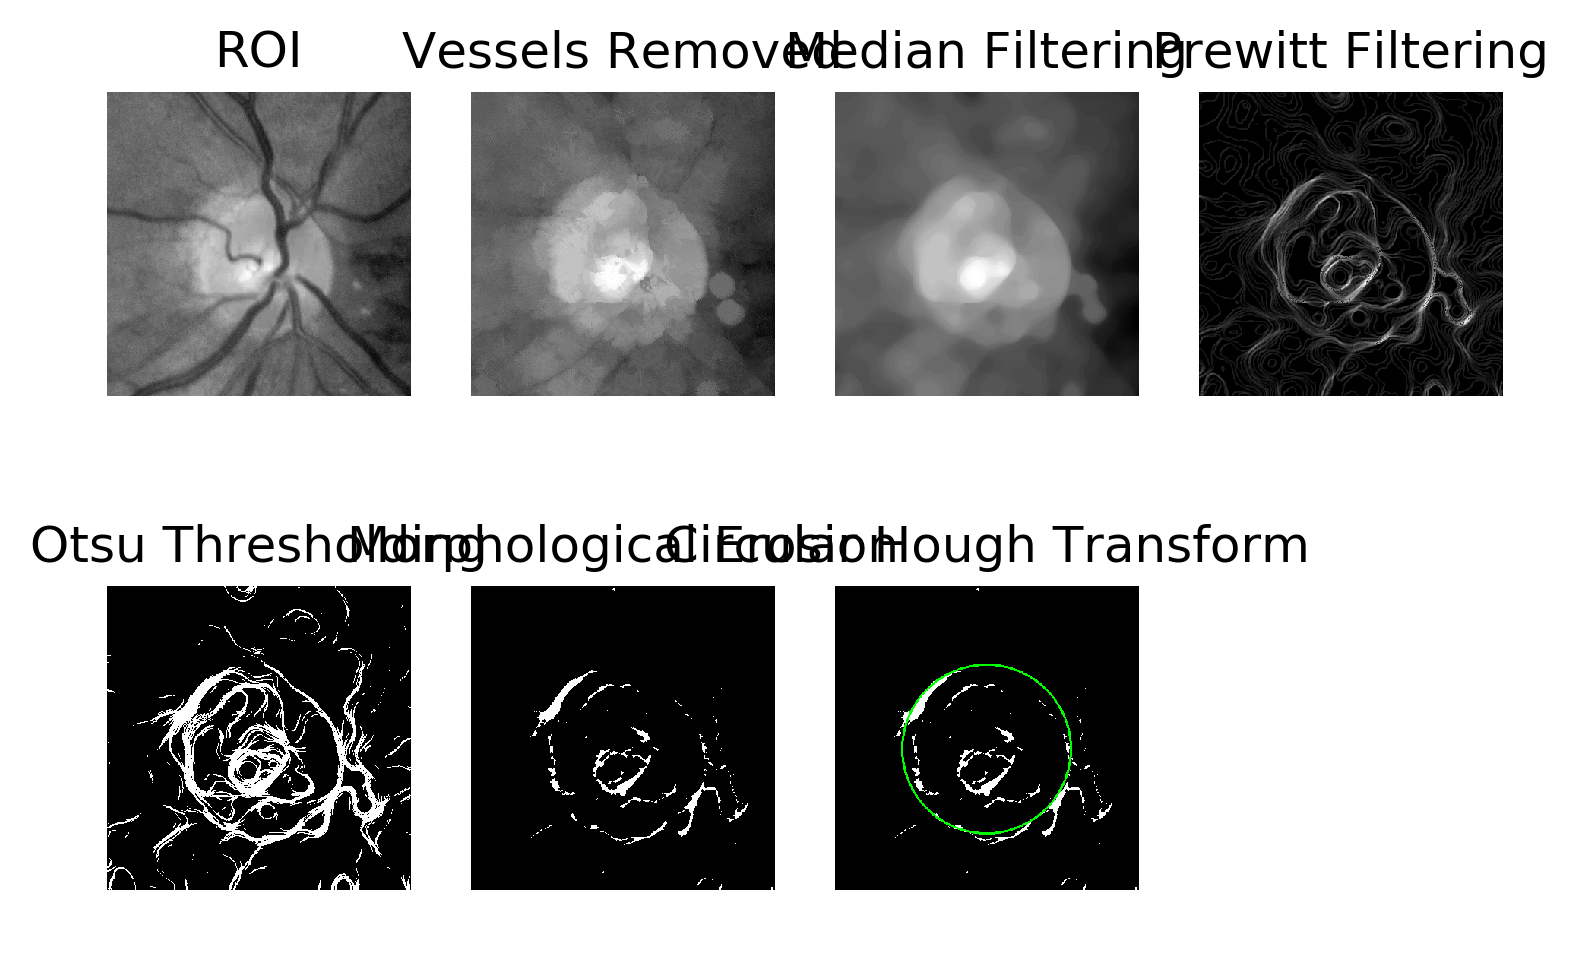

In [62]:
centre_g, radius_g = get_od(candidate_g)

Vessel Removal
Row 0
Row 20
Row 40
Row 60
Row 80
Row 100
Row 120
Row 140
Row 160
Row 180
Row 200
Row 220
Row 240
Row 260
Row 280
Row 300
Row 320
Row 340
Row 360
Row 380
Median
IG Map
30
Otsu
Erode
Hough


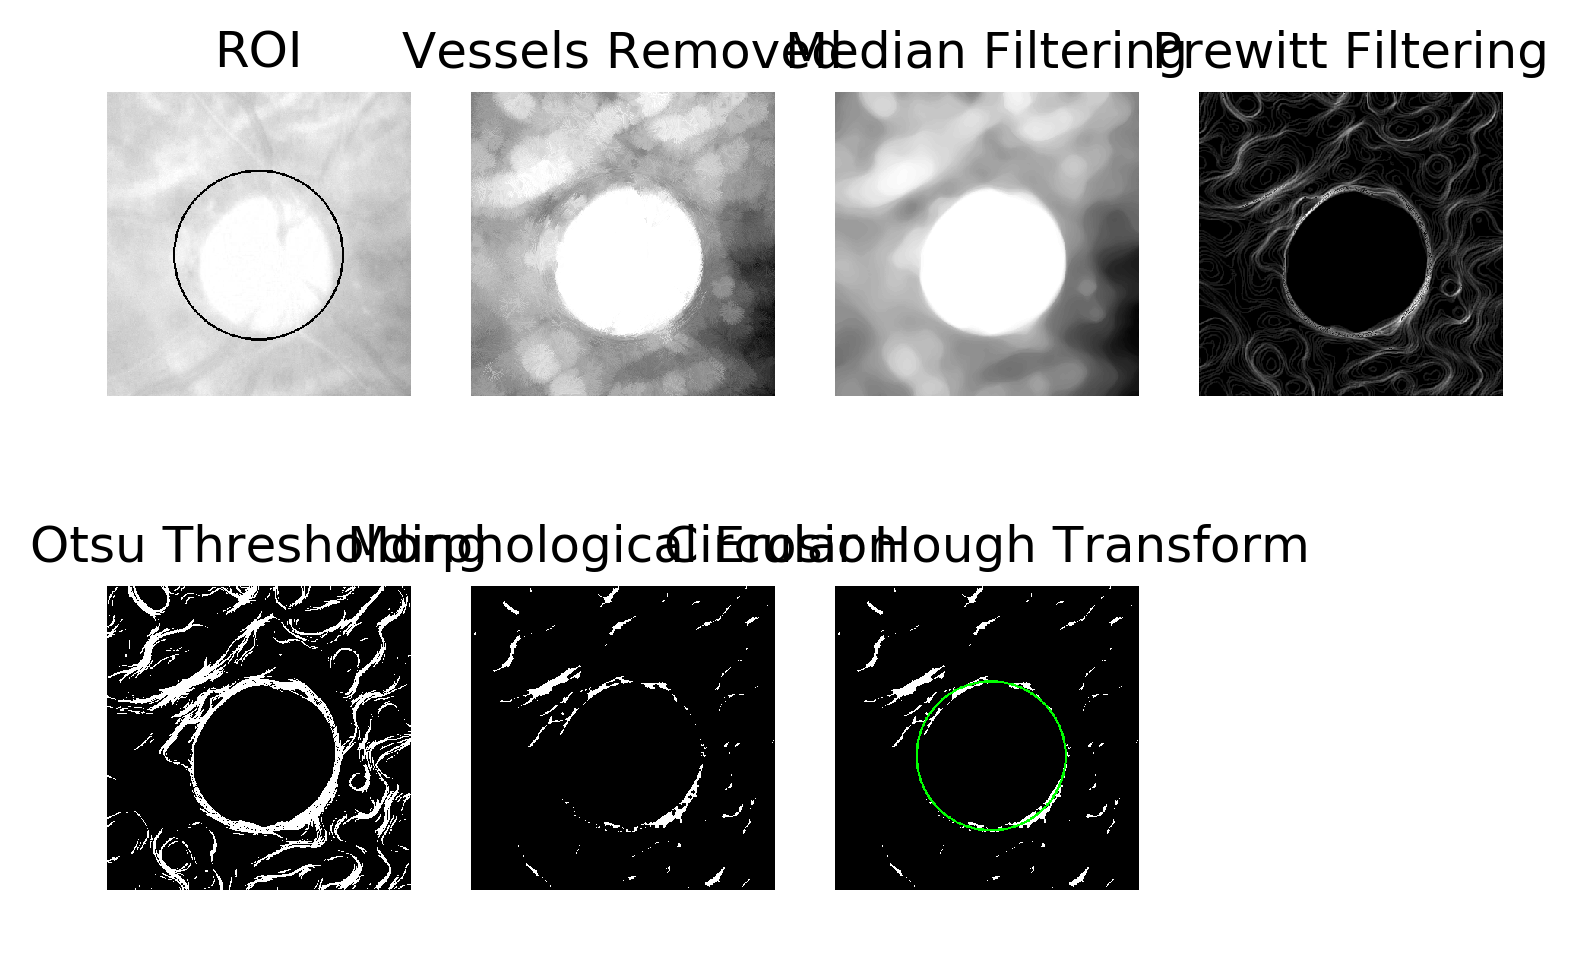

In [65]:
centre_r, radius_r = get_od(candidate_r)

In [78]:
shifted_centre_g_x = centre_g[0] + rect_top_left[0]
shifted_centre_g_y = centre_g[1] + rect_top_left[1]
cv2.circle(img, (shifted_centre_g_x, shifted_centre_g_y), radius_g-25, (0,255,0), 2)
showImage(img)

In [79]:
shifted_centre_r_x = centre_r[0] + rect_top_left[0]
shifted_centre_r_y = centre_r[1] + rect_top_left[1]
cv2.circle(img, (shifted_centre_r_x, shifted_centre_r_y), radius_r-25, (0,0,255), 2)
showImage(img)

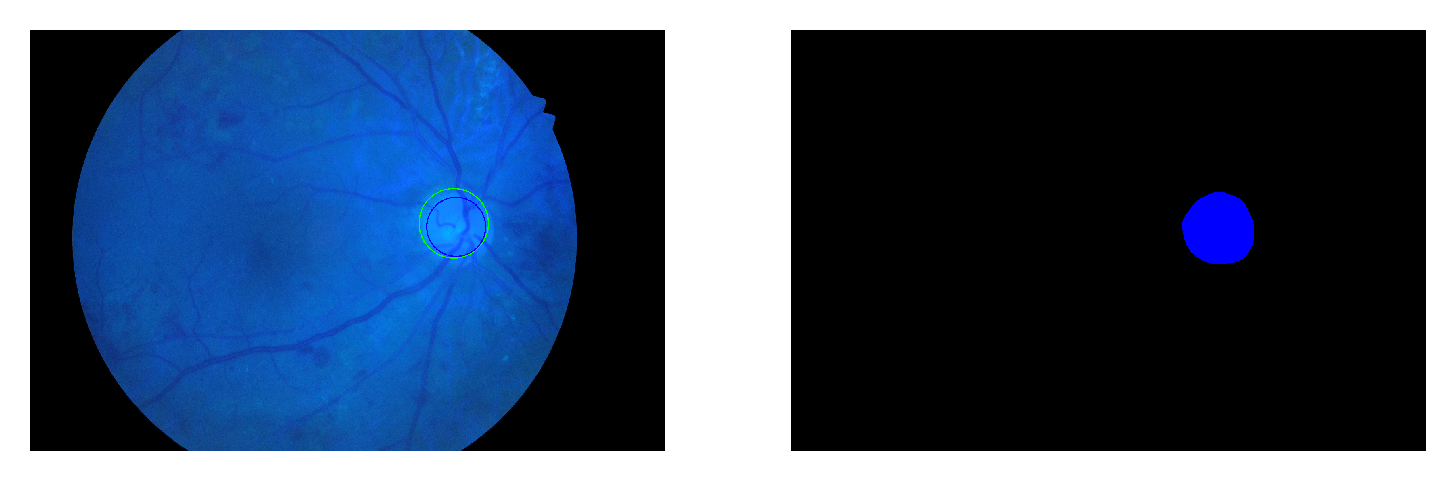

In [80]:
compare(img, truth_mask)

In [ ]:
debug_img.shape

In [ ]:
orig_img.shape